# Air Quality Analysis

This exercise is about air quality analysis, where you will predict air quality through solving classification and regression tasks.

## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors.

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`.

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
2261,0.9,1007.50,7.090258,860.75,260.0,858.00,149.0,990.75,1228.75,6.625,44.125000,0.433346
1385,2.2,908.25,7.676715,885.75,353.0,922.00,142.0,946.75,835.25,8.925,34.475000,0.394571
2972,1.6,1215.50,9.521023,959.50,87.0,787.75,92.0,1662.25,1255.75,17.900,56.200000,1.142047
191,3.7,1283.25,15.012927,1149.00,585.8,587.25,235.0,1148.25,1799.25,6.325,39.424999,0.379464
1536,2.6,951.25,9.351707,953.00,460.0,811.50,157.0,1022.25,1055.00,7.400,36.525000,0.377798


## 2. Linear Classification via Gradient Descent 

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad  (CO(GT)>4.5). You will perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH.

### 2.1 Model Training and Testing

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

Recall from your lectures that gradient descent is an iterative optimisation algorithm typically used in model training. Complete the implmentation of the training function `linear_gd_train` below, which trains your linear model by minimising the above provided training objective function $O$ using gradient descent.

The function should return the trained model weights and the corresponding objective function value (referred to as cost) per iteration. In addition to the training data, the function should take the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

In [28]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)
    n_samples, n_features = data.shape

    # Create design matrix and labels
    X_tilde = np.hstack([data, np.ones((n_samples, 1))])
    y = np.where(labels, 1, -1)

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    # w = rng.standard_normal(size = n_features + 1)
    w = np.zeros(n_features + 1)

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((n_iters, n_features + 1))
    cost_all = np.zeros(n_iters)

    # GD update of weights
    for i in range(n_iters):
        # Compute predictions
        predictions = X_tilde @ w

        # Compute the hinge loss component
        margins = 1 - y * predictions
        loss = np.maximum(0, margins)
        hinge_loss = np.sum(loss)

        # Compute the L2 regularization term
        l2_term = 0.5 * np.dot(w.T, w)

        # Cost and gradient update of the linear model
        cost = c * hinge_loss + l2_term

        gradient = -X_tilde.T @ (y * (margins > 0)) * c + w

        # Weight update
        w -= learning_rate * gradient

        # save w and cost of each iteration in w_all and cost_all
        w_all[i] = w
        cost_all[i] = cost

    # Return model parameters.
    return cost_all, w_all


def linear_predict(data, w):
    """
    A summary of your function goes here.

    data: test data
    w: model weights

    Returns the predicted labels.
    """
    # Add bias term to data
    X_tilde = np.hstack([data, np.ones((data.shape[0], 1))])
    predictions = X_tilde @ w

    # Predict labels
    y_pred = predictions >= 0

    return y_pred

Now, you are ready to conduct a complete experiment of air quality classification. The provided code below splits the data into training and testing sets and imputes the missing features.

In [29]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Write your code below, which should train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set. Note, use the default setting provided for $C$, $\eta$ and $N_{max}$. Your plot should have axis labels and titles.

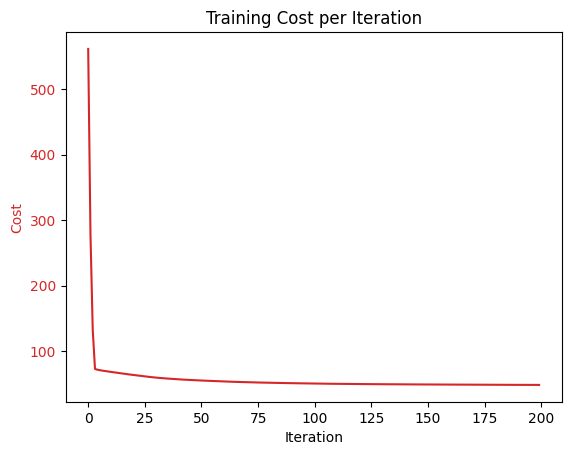

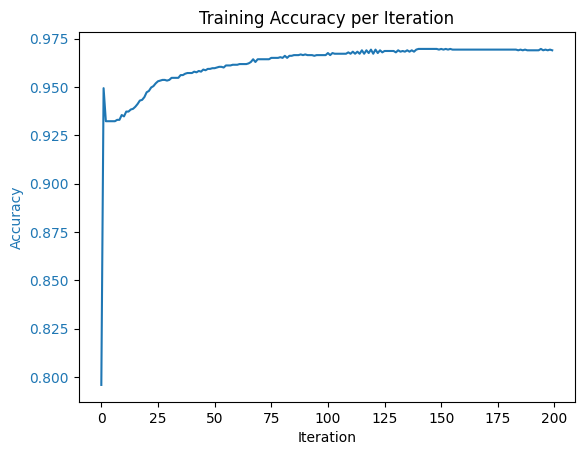

Accuracy on test set: 0.9637096774193549
F1 Score on test set: 0.7


In [30]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Train the model
costs, weights = linear_gd_train(train_X_cls, train_y_cls, c=0.2, n_iters=200, learning_rate=0.001)

# Plot accuracy and cost per iteration on training set
fig, ax1 = plt.subplots()
plt.title('Training Cost per Iteration')
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost', color=color)
ax1.plot(costs, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.show()

# Plot accuracy per iteration on training set
fig, ax2 = plt.subplots()
plt.title('Training Accuracy per Iteration')
color = 'tab:blue'
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy', color=color)
accuracy_per_iteration = [accuracy_score(train_y_cls, linear_predict(train_X_cls, w)) for w in weights]
ax2.plot(accuracy_per_iteration, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

# Apply imputation to the test set
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.transform(test_X_cls)

# Predict on test set, report accuracy and f1 score
final_weights = weights[-1]
predicted_labels = linear_predict(test_X_cls, final_weights)

test_accuracy = accuracy_score(test_y_cls, predicted_labels)
test_f1_score = f1_score(test_y_cls, predicted_labels)

print(f"Accuracy on test set: {test_accuracy}")
print(f"F1 Score on test set: {test_f1_score}")

### 2.2 Learning Rate Analysis

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. Design an appropriate experiment to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

Learning Rate: 0.1 | Test Set Accuracy: 0.907258064516129 | Test Set F1 Score: 0.0


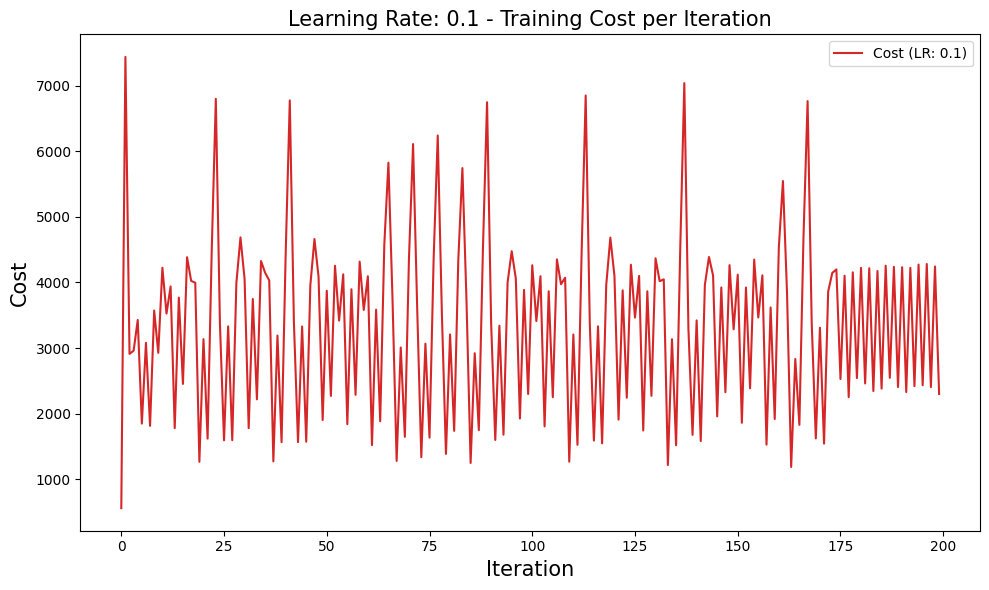

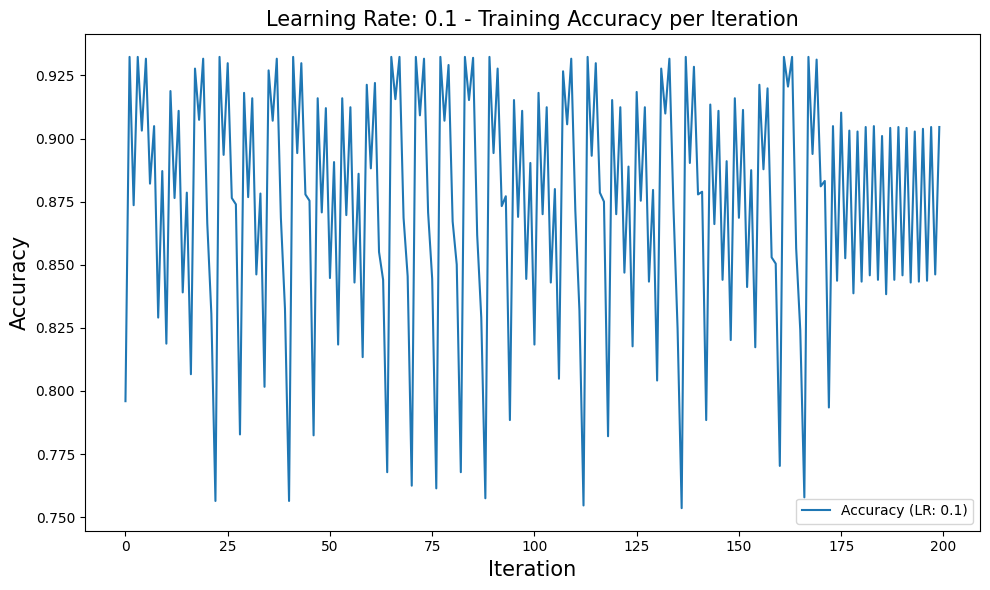

Learning Rate: 0.01 | Test Set Accuracy: 0.9435483870967742 | Test Set F1 Score: 0.33333333333333337


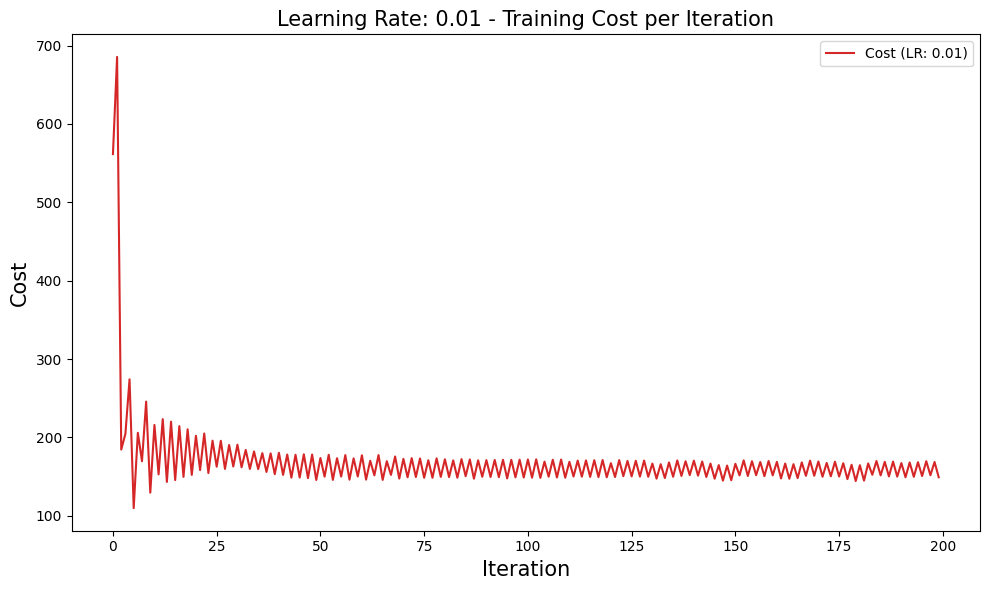

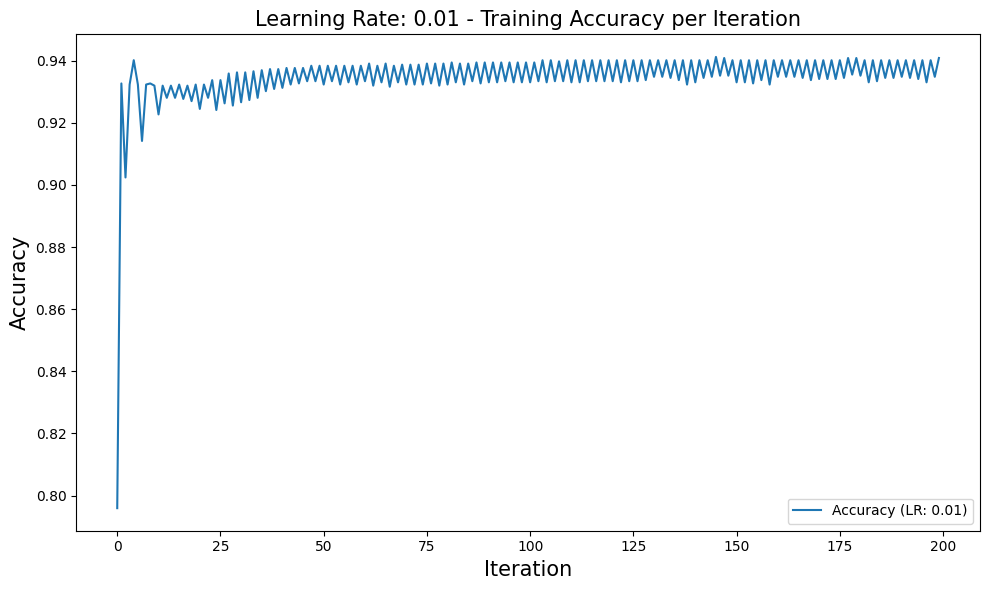

Learning Rate: 0.001 | Test Set Accuracy: 0.9637096774193549 | Test Set F1 Score: 0.7


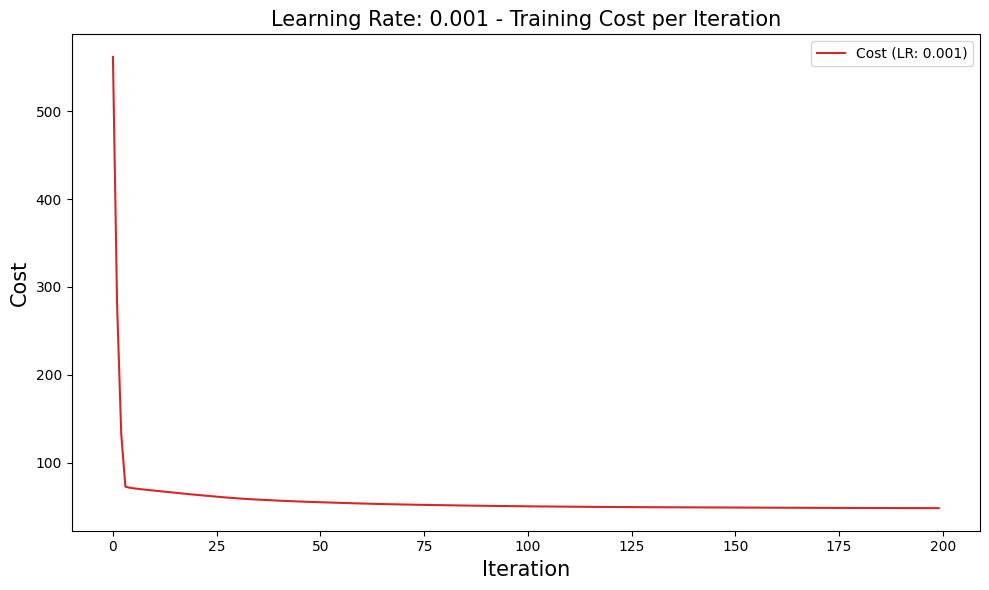

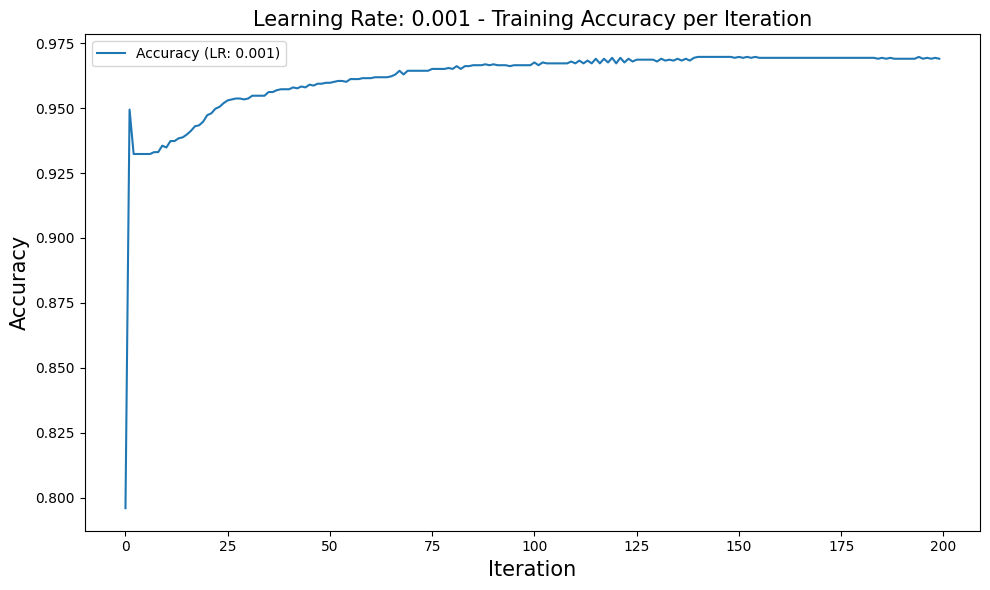

Learning Rate: 0.0001 | Test Set Accuracy: 0.9435483870967742 | Test Set F1 Score: 0.33333333333333337


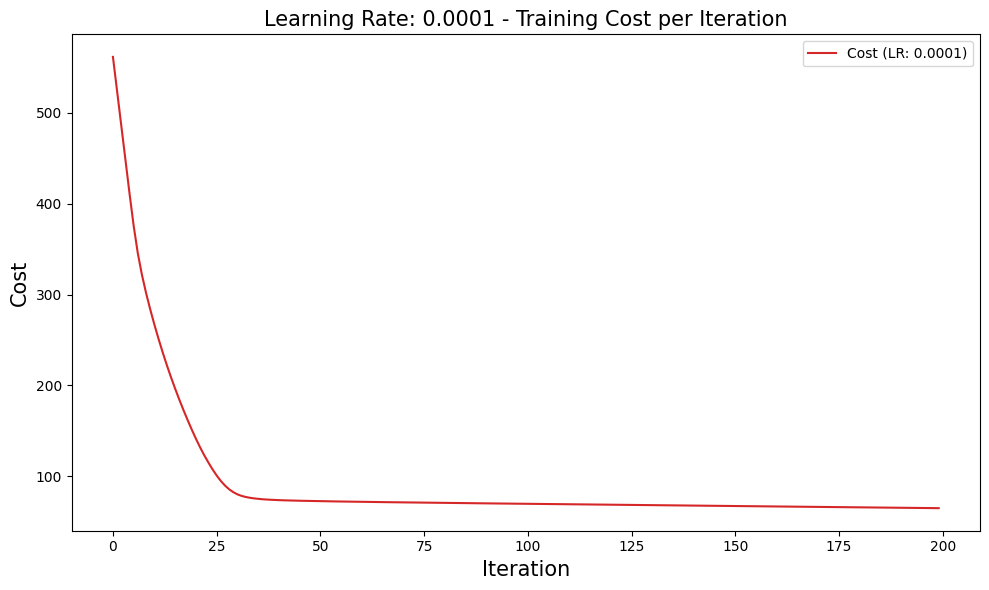

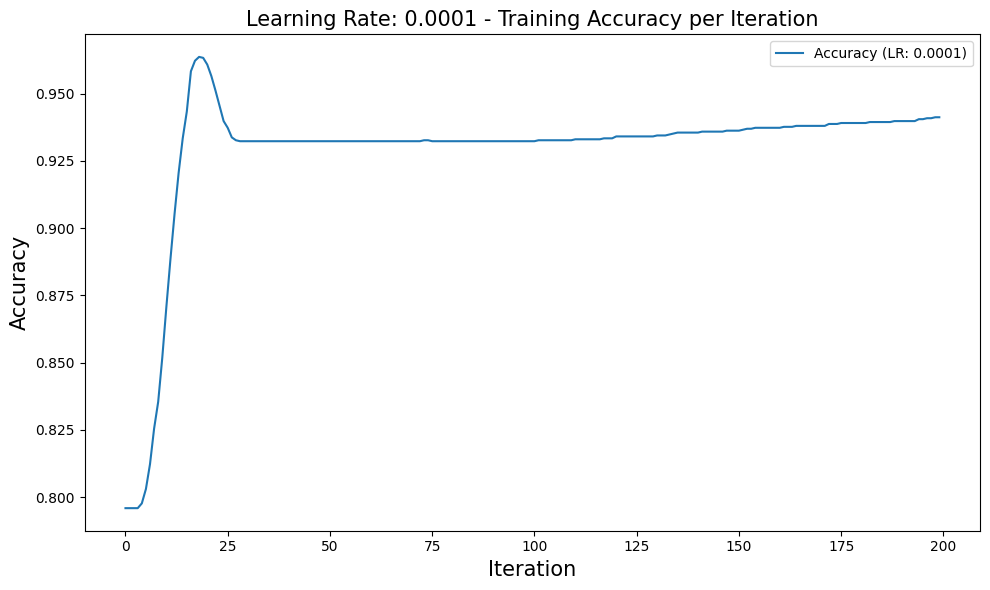

In [31]:
def analyze_learning_rates_separate(data, labels, test_data, test_labels, learning_rates, n_iters=200):
    # Train the model and plot the results for each learning rate
    for idx, lr in enumerate(learning_rates):
        # Train the model
        costs, weights = linear_gd_train(data, labels, c=0.2, n_iters=n_iters, learning_rate=lr)

        # Calculate accuracy and F1 score on the test set with the final weights
        final_weights = weights[-1]
        test_predicted_labels = linear_predict(test_data, final_weights)
        test_accuracy = accuracy_score(test_labels, test_predicted_labels)
        test_f1_score = f1_score(test_labels, test_predicted_labels)

        print(f"Learning Rate: {lr} | Test Set Accuracy: {test_accuracy} | Test Set F1 Score: {test_f1_score}")

        # Calculate accuracy per iteration on the training set
        accuracies = [accuracy_score(labels, linear_predict(data, w)) for w in weights]

        # Create a new figure for each learning rate
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the cost for this learning rate
        ax.plot(costs, label=f'Cost (LR: {lr})', color='tab:red')
        ax.set_title(f'Learning Rate: {lr} - Training Cost per Iteration', fontsize=15)
        ax.set_xlabel('Iteration', fontsize=15)
        ax.set_ylabel('Cost', fontsize=15)
        ax.legend()

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

        # Create a new figure for each learning rate
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the accuracy for this learning rate
        ax.plot(accuracies, label=f'Accuracy (LR: {lr})', color='tab:blue')
        ax.set_title(f'Learning Rate: {lr} - Training Accuracy per Iteration', fontsize=15)
        ax.set_xlabel('Iteration', fontsize=15)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.legend()

        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

# Learning rates to test
learning_rates_to_test = [0.1, 0.01, 0.001, 0.0001]

# Analyze learning rates using the user's training and test sets
analyze_learning_rates_separate(train_X_cls, train_y_cls, test_X_cls, test_y_cls, learning_rates_to_test)


## 3. Air Quality Analysis by Neural Network

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression).


### 3.1 Simple MLP Model Selection

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures.

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training.

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [33]:
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Redo split for regression
X = sensor_data_full.drop('CO(GT)', axis=1).values
y = sensor_data_full['CO(GT)'].values

# Prepare the data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.15, random_state=42)

imputer = SimpleImputer(missing_values=-999, strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define MLP model
mlp = MLPRegressor(random_state=42)

# Initialise and fit the grid search
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Report the best parameters and the CV results
best_mlp = grid_search.best_estimator_
cv_results = grid_search.cv_results_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Cross-validation (1) MSE: {-grid_search.best_score_}, (2) std: {cv_results['std_test_score'][grid_search.best_index_]}")

# Report model performance
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R^2 score: {test_r2}")

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100)}
Cross-validation (1) MSE: 0.16552146895794861, (2) std: 0.026956136872979014
Test MSE: 0.22178767113233006
Test R^2 score: 0.9001874432105156


### 3.2 Training Algorithm Comparison: SGD and ADAM

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [34]:
test_params = [
    {
        'activation': 'relu',
        'alpha': 0.001,
        'early_stopping': False,
        'hidden_layer_sizes': (100, 100),
        'solver': 'adam'
    },{
        'activation': 'relu',
        'alpha': 0.001,
        'early_stopping': False,
        'hidden_layer_sizes': (100, 100),
        'learning_rate': 'adaptive',
        'momentum': 0.95,
        'solver': 'sgd'
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set.

Final Test MSE (adam): 0.18164602975895167
Final R² Score (adam): 0.9182526487232823


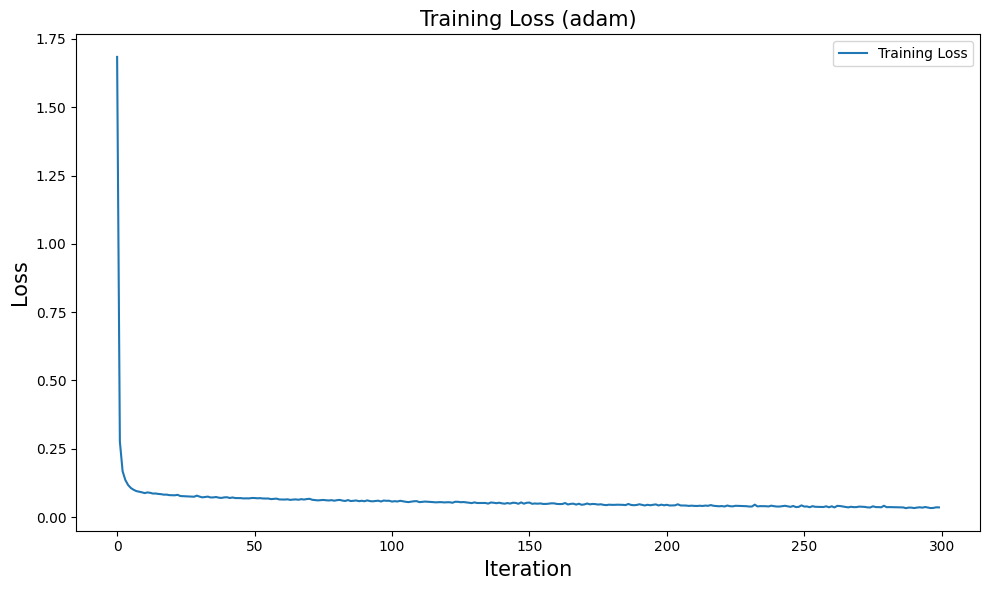

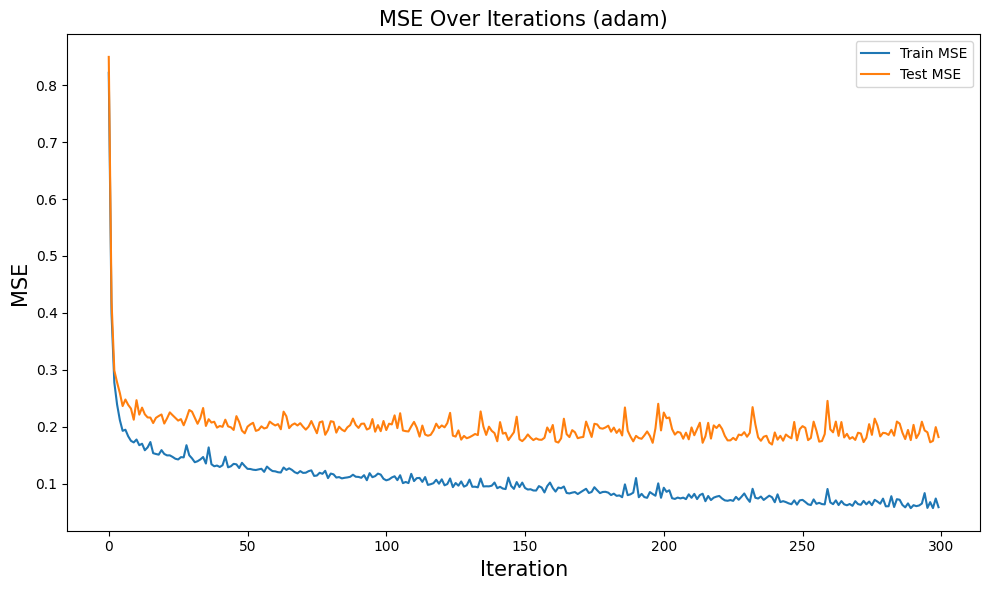

Final Test MSE (sgd): 0.21720139960837284
Final R² Score (sgd): 0.9022514329922733


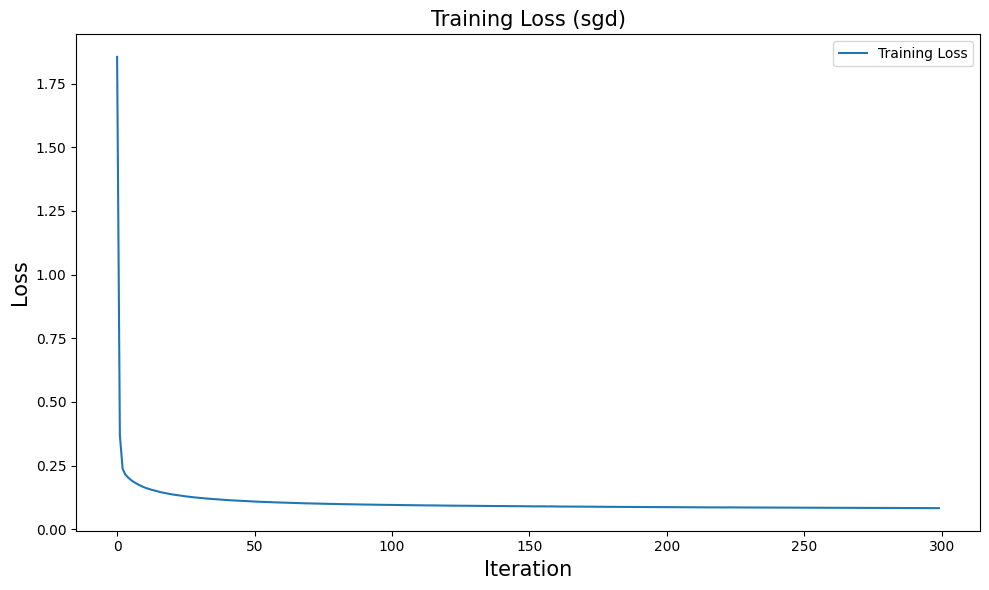

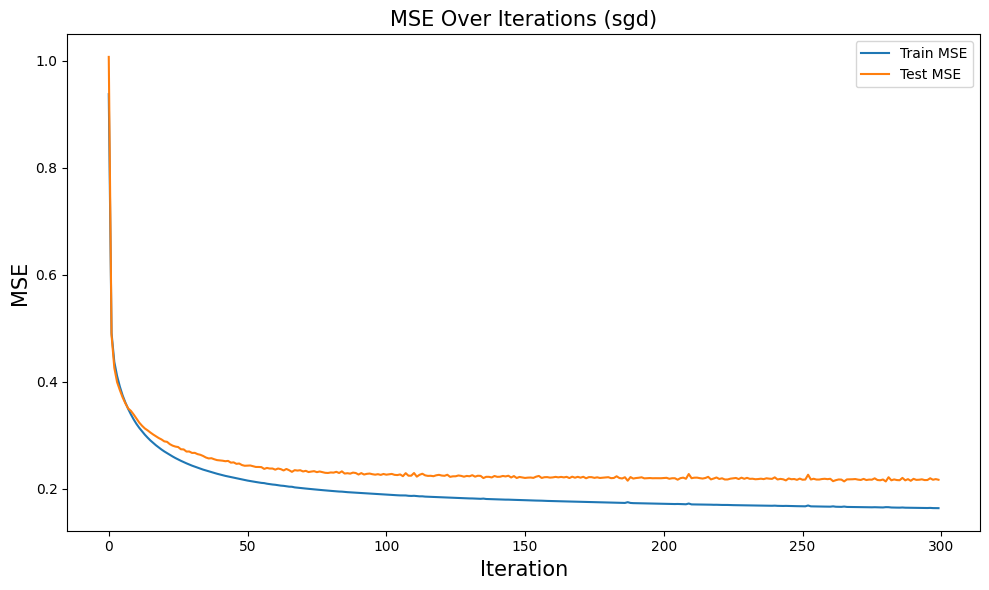

In [35]:
for idx, param in enumerate(test_params):
    model = MLPRegressor(**param, max_iter=1, warm_start=True)  # incremental learning
    train_mse = []
    test_mse = []
    train_losses = []

    # Incremental training for 300 iterations
    for _ in range(300):
        model.fit(X_train, y_train)
        train_losses.append(model.loss_)
        train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, model.predict(X_test)))

    # Plotting training loss
    fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
    ax_loss.plot(train_losses, label='Training Loss')
    ax_loss.set_title(f"Training Loss ({param['solver']})", fontsize=15)
    ax_loss.set_xlabel('Iteration', fontsize=15)
    ax_loss.set_ylabel('Loss', fontsize=15)
    ax_loss.legend()
    plt.tight_layout()

    # Print final performance metrics
    final_test_mse = test_mse[-1]
    final_r2 = r2_score(y_test, model.predict(X_test))
    print(f"Final Test MSE ({param['solver']}): {final_test_mse}")
    print(f"Final R² Score ({param['solver']}): {final_r2}")
    plt.show()

    # Plotting MSE
    fig_mse, ax_mse = plt.subplots(figsize=(10, 6))
    ax_mse.plot(train_mse, label='Train MSE')
    ax_mse.plot(test_mse, label='Test MSE')
    ax_mse.set_title(f"MSE Over Iterations ({param['solver']})", fontsize=15)
    ax_mse.set_xlabel('Iteration', fontsize=15)
    ax_mse.set_ylabel('MSE', fontsize=15)
    ax_mse.legend()
    plt.tight_layout()
    plt.show()


## 4.  Build A Robust MLP Regressor 

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features.

Once you have developed your model, save it to a file using the provided `save_model` function.

### 4.1 Model Development

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [36]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval

# Data preprocessing
X = sensor_data_full.drop('CO(GT)', axis=1)
y = sensor_data_full['CO(GT)']

# Replace -999 with NaN
X.replace(-999, np.nan, inplace=True)

# Replace missing values using KNNImputer
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)

# Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define hyperparameter space
space = {
    'hidden_layer_sizes': hp.choice('num_layers', [
        (hp.randint('neurons_in_layer2_1', 50, 150), hp.randint('neurons_in_layer2_2', 50, 150)),
        (hp.randint('neurons_in_layer3_1', 50, 150), hp.randint('neurons_in_layer3_2', 50, 150), hp.randint('neurons_in_layer3_3', 50, 100)),
        ]),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e-2)),
    'early_stopping': True,  # Activate early stopping
    'validation_fraction': 0.1,   # Validation data fraction for early stopping
    'n_iter_no_change': 10  # Iterations to stop if no improvement
}

# Define the objective function
def objective(params):
    mlp = MLPRegressor(**params, max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    pred = mlp.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return {'loss': mse, 'status': STATUS_OK}

# Execute optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)
# Retrain model with best hyperparameters
best_params = space_eval(space, best)
best_model = MLPRegressor(**best_params, max_iter=500, random_state=42)
best_model.fit(X_train, y_train)

# Get performance metrics
pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("Best hyperparameters:", best_params)
print("Test MSE:", mse)
print("Test R^2 Score:", r2)